# Polarized CBO

In [1]:
%load_ext autoreload
%autoreload 2
from cbx.objectives import snowflake
from cbx.dynamics import PolarCBO
from cbx.plotting import plot_dynamic_history
from cbx.scheduler import multiply
import matplotlib.pyplot as plt
import numpy as np
#%%
np.random.seed(42)
f = snowflake()
N = 100
x = np.random.uniform(-2., 2., (2,N,2))

dyn = PolarCBO(f, d=2,
          x=x,
          alpha=1.,
          #noise='anisotropic',
          sigma=2.,
          kappa=1.5,
          verbosity=0,
          track_args={'names':[
            'x', 
            'consensus', 
            'drift']},
          batch_args={'size':50})
dyn.optimize(sched = multiply(factor=1.02, maximum=1e10))

array([[-1.46131963e+00,  8.43696484e-01],
       [ 1.83423480e-07, -1.70871091e+00]])

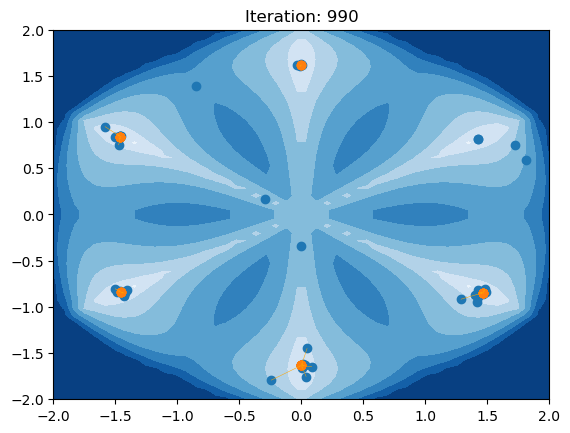

In [2]:
import matplotlib.pyplot as plt
from IPython import display

fig, ax = plt.subplots(1,)
pl = plot_dynamic_history(
    dyn, ax=ax,
    objective_args={'x_min':-2, 'x_max':2, 'cmap':'Blues'},
    plot_consensus=True,
    plot_drift=True
)
for i in range(0, pl.max_it,10):
    pl.plot_at_ind(i)
    pl.decorate_at_ind(i)
    display.display(fig)
    display.clear_output(wait=True)
    plt.pause(0.1)